In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, datetime
import numpy as np
from scipy import stats


In [2]:
df = pd.read_csv('SBAnational.csv')

/tmp/ipykernel_5041/2640212651.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('SBAnational.csv')


In [4]:
df['ApprovalDate'].sort_values().unique()

array(['1-Apr-02', '1-Apr-03', '1-Apr-04', ..., '9-Sep-97', '9-Sep-98',
       '9-Sep-99'], shape=(9859,), dtype=object)

In [5]:
# le nombre de banques 

len(df['Bank'].unique())

5803

In [6]:
# nombre d'états des banques qui sont étudiées

len(df['BankState'].unique())

57

In [7]:
# LE nombre de secteurs d'activité

len(df['NAICS'].astype(str).str.slice(0,2).unique())

25

In [8]:
# nb états des clients

len(df['State'].unique())

52

In [9]:
df['RetainedJob'].unique()

array([   0,    7,   23,    4,    6,    1,    9,   20,    2,    5,   19,
          8,    3,   10,   24,   12,   15,   11,   25,   44,   17,   14,
         65,   28,   38,   16,   42,   26,   18,   13,   50,   93,   40,
         37,   60,   21,   30,   31,   34,   35,  150,   22,   73,   41,
         45,  100,  180,   58,   75,  165,   36,  130,   29,   27,  125,
         99,   46,   32,  257,   43,   47,   80,   70,   54,   62,   33,
         39,  400,   55,   95,   48,  120,   71,   63,   81,   52,   94,
         78,  160,  109,   86,   77,  155,   85,   90,   64, 3225,   61,
         69,   66,  210,  107,   97,   51,   83,  112,   53,   72,   76,
         87,   68,  118,  138,   67,   57,   56,  117,  171,  229,  115,
        275,  153,  300,  105,  140,  135,   59,   79,  200,  295,  205,
        206,  128,  186,  137,  250,   89,   49,  131,   92,  404,  110,
        320,  139,   82,  108,   88,  104,  114,  134,  230,  102,  103,
         96,   98,   84,  101,  220,  233,   74,  2

In [10]:
df.nunique()

LoanNr_ChkDgt        899164
Name                 779583
City                  32581
State                    51
Zip                   33611
Bank                   5802
BankState                56
NAICS                  1312
ApprovalDate           9859
ApprovalFY               70
Term                    412
NoEmp                   599
NewExist                  3
CreateJob               246
RetainedJob             358
FranchiseCode          2768
UrbanRural                3
RevLineCr                18
LowDoc                    8
ChgOffDate             6448
DisbursementDate       8472
DisbursementGross    118859
BalanceGross             15
MIS_Status                2
ChgOffPrinGr          83165
GrAppv                22128
SBA_Appv              38326
dtype: int64

In [11]:
df.duplicated()[df.duplicated() == True]

Series([], dtype: bool)

In [3]:
df_2 = df.copy()

#Création de la colonne categorie activité
df_2['cat_activites'] = df['NAICS'].map(lambda x: str(x)[:2])

#Remplace les années avec 1976A par 1976 et passage en INT

df_2.replace('1976A',1976, inplace= True)
df_2['ApprovalFY'] = pd.to_numeric(df_2['ApprovalFY'])

# supprime le dollar et formate
df_2['SBA_loan_float'] = df_2['SBA_Appv'].map(lambda x : float(x[1:].replace(',','')))
df_2['bank_loan_float'] = df_2['GrAppv'].map(lambda x : float(x[1:].replace(',','')))


# Nettoyage de la colonne lowdoc le programme a été créé en 1993 avec les condtions d'être en dessous de 150000 dollars de prêt
df_2['LowDoc'] = df_2.apply(
    lambda row: row['LowDoc'] if row['LowDoc'] in ['Y', 'N']
    else ('N' if row['ApprovalFY'] < 1993 else ('N' if row['bank_loan_float'] > 150000 else 'Y')), axis=1)


# Formatage et de nettoyage de la colonne Approuval Date
# Modifier les années en fonction de la condition
df_2['ApprovalDate'] = df_2['ApprovalDate'].map(
    lambda x: x.replace(x[-3:], '-19' + x[-2:]) if int(x[-2:]) >= 50 else x.replace(x[-3:], '-20' + x[-2:])
)
df_2['ApprovalDate'] = pd.to_datetime(df_2['ApprovalDate'])

#Impute la valeur MIS_Status selon la valeur ChgOffDate (S'il y a une date de défaut, c'est que le prêt n'a pas été remboursé dans son entierté.)
df_2.loc[df_2["MIS_Status"].isna(), "MIS_Status"] = df_2["ChgOffDate"].notna().map({True: "CHGOFF", False: "P I F"})

# retirer les null dans state

#Trie le DataFrame par zip code en ordre ascendant
df_sorted = df_2.sort_values(by='Zip')

# Regroupe le DataFrame par Zip code
grouped = df_sorted.groupby('Zip')# Regroupe le DataFrame par Zip code
#Remplace les cellules State vides par la valeur State non-nulle correspondante dans chaque groupe
df_sorted['State'] = grouped['State'].fillna(method='ffill')
df_2 = df_sorted.sort_index()

#Remplace la dernière cellule vide par l'état AP pour base américaine
df_2 = df_2.fillna({'State':'AP'})


annee_crise = [1960,1961,1969,1970,1973,1974,1980,1981,1982,2000,2001,2007,2008]
df_2['crisis'] = df['ApprovalFY'].apply(lambda x : 1 if x in annee_crise else 2)



df_2.to_csv('dataset.csv', index = False)


/tmp/ipykernel_5041/3457817455.py:40: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df_sorted['State'] = grouped['State'].fillna(method='ffill')
/tmp/ipykernel_5041/3457817455.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sorted['State'] = grouped['State'].fillna(method='ffill')
/tmp/ipykernel_5041/3457817455.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sorted['State'] = grouped['State'].fillna(method='ffill')


In [26]:
df_2[["State", "City"]]

,State,City
0,IN,EVANSVILLE
1,IN,NEW PARIS
2,IN,BLOOMINGTON
3,OK,BROKEN ARROW
4,FL,ORLANDO
...,...,...
899159,OH,UPPER ARLINGTON
899160,OH,COLUMBUS
899161,CA,SANTA MARIA
899162,HI,HONOLULU


In [24]:
# Sort the DataFrame by 'Zip Code' in ascending order
df_sorted = df_2.sort_values(by='Zip')

# Group the DataFrame by 'Zip Code'
grouped = df_sorted.groupby('Zip')

# Fill the null 'State' values with the corresponding non-null 'State' value within each group
df_sorted['State'] = grouped['State'].fillna(method='ffill')
df_2 = df_sorted.sort_index()

df_2 = df_2.fillna({'State':'AP'})

/tmp/ipykernel_16968/3326069029.py:8: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df_sorted['State'] = grouped['State'].fillna(method='ffill')
/tmp/ipykernel_16968/3326069029.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sorted['State'] = grouped['State'].fillna(method='ffill')
/tmp/ipykernel_16968/3326069029.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sorted['State'] = grouped['State'].fillna(method='ffill')


In [25]:
df_2[df_2["State"].isna()]


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,cat_activites,SBA_loan_float,bank_loan_float


In [44]:
df_2["MIS_Status"].isna().sum()

np.int64(0)

In [13]:
df_2[df_2['NAICS'] == 0]

#200K plus lignes qui ont un NAICS qui est de 0

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,cat_activites,SBA_loan_float,bank_loan_float
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,1997-02-28,1997,...,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00",0,28000.0,35000.0
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,1997-02-28,1997,...,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00",0,229000.0,229000.0
6,1000093009,MIDDLE ATLANTIC SPORTS CO INC,UNION,NJ,7083,WELLS FARGO BANK NATL ASSOC,SD,0,1980-06-02,1980,...,22-Jul-80,"$600,000.00",$0.00,CHGOFF,"$208,959.00","$600,000.00","$499,998.00",0,499998.0,600000.0
9,1000124001,INTEXT BUILDING SYS LLC,GLASTONBURY,CT,6073,WEBSTER BANK NATL ASSOC,CT,0,1997-02-28,1997,...,30-Apr-97,"$70,000.00",$0.00,P I F,$0.00,"$70,000.00","$56,000.00",0,56000.0,70000.0
13,1000154010,"ORCHARD CAFE & BAKERY, INC.",SLATERSVILLE,RI,2876,CITIZENS BANK NATL ASSOC,RI,0,1997-02-28,1997,...,31-May-97,"$370,000.00",$0.00,P I F,$0.00,"$370,000.00","$277,500.00",0,277500.0,370000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899153,9995413002,NORTH SHORE FLORAL,WOODBURY,NY,11797,FLUSHING BANK,NY,0,1997-02-27,1997,...,31-May-97,"$142,000.00",$0.00,CHGOFF,$0.00,"$142,000.00","$106,500.00",0,106500.0,142000.0
899154,9995423005,"LITWIN LIVERY SERVICES, INC.",CAMPBELL,OH,44405,JPMORGAN CHASE BANK NATL ASSOC,IL,0,1997-02-27,1997,...,30-Sep-97,"$10,000.00",$0.00,P I F,$0.00,"$10,000.00","$5,000.00",0,5000.0,10000.0
899158,9995563001,SHADES WINDOW TINTING AUTO ALA,IRVING,TX,75062,LOANS FROM OLD CLOSED LENDERS,DC,0,1997-02-27,1997,...,30-Jun-97,"$79,000.00",$0.00,P I F,$0.00,"$79,000.00","$63,200.00",0,63200.0,79000.0
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,0,1997-02-27,1997,...,31-Mar-97,"$75,000.00",$0.00,CHGOFF,"$46,383.00","$75,000.00","$60,000.00",0,60000.0,75000.0


In [14]:
from datetime import datetime

df_2['dif_days_aproved_received'] = pd.to_datetime(df_2['DisbursementDate']) - pd.to_datetime(df_2['ApprovalDate'])

df_2

/tmp/ipykernel_10526/984317455.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_2['dif_days_aproved_received'] = pd.to_datetime(df_2['DisbursementDate']) - pd.to_datetime(df_2['ApprovalDate'])


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,cat_activites,SBA_loan_float,bank_loan_float,dif_days_aproved_received
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997-02-28,1997,...,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00",45,48000.0,60000.0,730 days
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,1997-02-28,1997,...,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00",72,32000.0,40000.0,92 days
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,1997-02-28,1997,...,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00",62,215250.0,287000.0,306 days
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,1997-02-28,1997,...,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00",0,28000.0,35000.0,122 days
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,1997-02-28,1997,...,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00",0,229000.0,229000.0,75 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,1997-02-27,1997,...,"$70,000.00",$0.00,P I F,$0.00,"$70,000.00","$56,000.00",45,56000.0,70000.0,215 days
899160,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,1997-02-27,1997,...,"$85,000.00",$0.00,P I F,$0.00,"$85,000.00","$42,500.00",45,42500.0,85000.0,246 days
899161,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,1997-02-27,1997,...,"$300,000.00",$0.00,P I F,$0.00,"$300,000.00","$225,000.00",33,225000.0,300000.0,215 days
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,0,1997-02-27,1997,...,"$75,000.00",$0.00,CHGOFF,"$46,383.00","$75,000.00","$60,000.00",0,60000.0,75000.0,32 days


In [15]:

df_2['ratio_SBA_bank'] = df_2['SBA_Appv'].map(lambda x : float(x[1:].replace(',',''))) / df_2['GrAppv'].map(lambda x : float(x[1:].replace(',','')))
df_2

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,cat_activites,SBA_loan_float,bank_loan_float,dif_days_aproved_received,ratio_SBA_bank
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997-02-28,1997,...,$0.00,P I F,$0.00,"$60,000.00","$48,000.00",45,48000.0,60000.0,730 days,0.80
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,1997-02-28,1997,...,$0.00,P I F,$0.00,"$40,000.00","$32,000.00",72,32000.0,40000.0,92 days,0.80
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,1997-02-28,1997,...,$0.00,P I F,$0.00,"$287,000.00","$215,250.00",62,215250.0,287000.0,306 days,0.75
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,1997-02-28,1997,...,$0.00,P I F,$0.00,"$35,000.00","$28,000.00",0,28000.0,35000.0,122 days,0.80
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,1997-02-28,1997,...,$0.00,P I F,$0.00,"$229,000.00","$229,000.00",0,229000.0,229000.0,75 days,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,1997-02-27,1997,...,$0.00,P I F,$0.00,"$70,000.00","$56,000.00",45,56000.0,70000.0,215 days,0.80
899160,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,1997-02-27,1997,...,$0.00,P I F,$0.00,"$85,000.00","$42,500.00",45,42500.0,85000.0,246 days,0.50
899161,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,1997-02-27,1997,...,$0.00,P I F,$0.00,"$300,000.00","$225,000.00",33,225000.0,300000.0,215 days,0.75
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,0,1997-02-27,1997,...,$0.00,CHGOFF,"$46,383.00","$75,000.00","$60,000.00",0,60000.0,75000.0,32 days,0.80


In [16]:
# Suppression des lignes où le NewExist est égale à 0

df_2 = df_2[df_2['NewExist'] != 0]

In [17]:
#NB EST LA TABLE D'un group by entre mis status et newexist au final la donnée sur newexiste n'est pas pertinente

nb_mis = df_2.groupby(['MIS_Status', 'NewExist'])['NewExist'].count().reset_index(name='count')


nb_mis['ratio'] = nb_mis.apply(lambda row: 
                               row['count'] / nb_mis[nb_mis['MIS_Status'] == 'CHGOFF']['count'].sum() 
                               if row['MIS_Status'] == 'CHGOFF' 
                               else row['count'] / nb_mis[nb_mis['MIS_Status'] == 'P I F']['count'].sum(), 
                               axis=1)

nb_mis

,MIS_Status,NewExist,count,ratio
0,CHGOFF,1.0,110114,0.699221
1,CHGOFF,2.0,47367,0.300779
2,P I F,1.0,533332,0.722159
3,P I F,2.0,205192,0.277841


In [18]:
df_2['MIS_Status'].isna()

0         False
1         False
2         False
3         False
4         False
          ...  
899159    False
899160    False
899161    False
899162    False
899163    False
Name: MIS_Status, Length: 898130, dtype: bool

In [19]:
len(df_2['Zip'].astype(str).str[:2].unique())

100

In [20]:
pd.to_numeric(df_2['ApprovalFY'][df_2['ApprovalFY'] != '1976A']).sort_values().unique()



array([1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014])

In [21]:
df_2.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv',
       'cat_activites', 'SBA_loan_float', 'bank_loan_float',
       'dif_days_aproved_received', 'ratio_SBA_bank'],
      dtype='object')

In [22]:
df_2_annee_MIS = df_2[['ApprovalFY', 'MIS_Status']]


df_2_annee_MIS_group = df_2_annee_MIS.groupby(['ApprovalFY','MIS_Status']).size()

df_2_annee_MIS_group_df = pd.DataFrame(df_2_annee_MIS_group).reset_index()
df_2_annee_MIS_group_df.columns = ['years', 'status','nb']
# Définir les intervalles de gravité des crises économiques
bins = [1968, 1972, 1979, 1991, 1997, 2002, 2008, 2014]
labels = ['Faible', 'Modéré', 'Moins grave', 'Modéré', 'Grave', 'Faible', 'Très grave']

# Appliquer pd.cut() pour classer les années selon les intervalles
df_2_annee_MIS_group_df['Crise Économique'] = pd.cut(df_2_annee_MIS_group_df['years'], bins=bins, labels=labels, right=False, ordered=False)

pd.set_option('display.max_rows', 120)
df_2_annee_MIS_group_df.head(118)

,years,status,nb,Crise Économique
0,1969,P I F,1,Faible
1,1970,CHGOFF,7,Faible
2,1970,P I F,1,Faible
3,1971,CHGOFF,18,Faible
4,1972,CHGOFF,21,Modéré
5,1972,P I F,4,Modéré
6,1973,CHGOFF,45,Modéré
7,1973,P I F,4,Modéré
8,1974,CHGOFF,40,Modéré
9,1974,P I F,2,Modéré


<Axes: xlabel='years', ylabel='nb'>

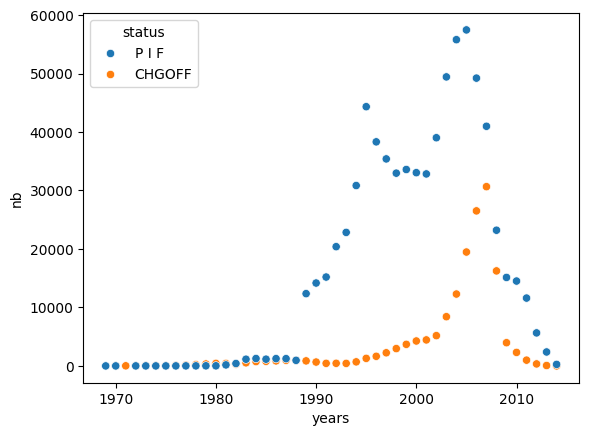

In [23]:
sns.scatterplot(x = "years", 
                y = "nb", 
                data = df_2_annee_MIS_group_df, 
                hue = "status")

<Axes: xlabel='years', ylabel='total_loan_bank'>

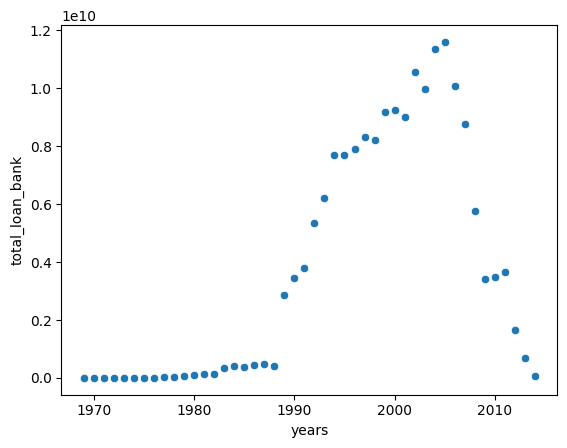

In [24]:
df_2_sum_years = df_2.groupby('ApprovalFY')['bank_loan_float'].sum()


df_2_sum_years = pd.DataFrame(df_2_sum_years).reset_index()
df_2_sum_years.columns = ['years', 'total_loan_bank']

sns.scatterplot(x = "years", 
                y = "total_loan_bank", 
                data = df_2_sum_years, 
                #hue = "status"
                )



<Axes: xlabel='years', ylabel='total_loan_SBA'>

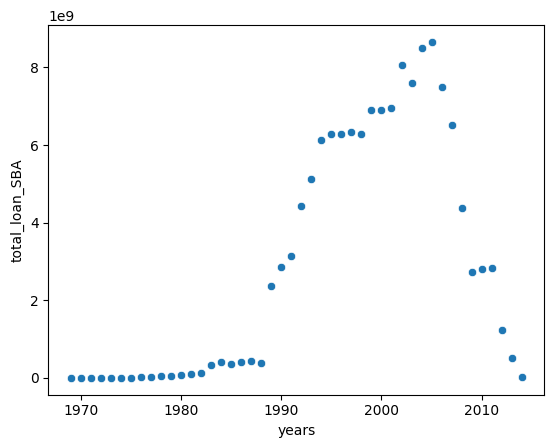

In [25]:
df_2_sum_years = df_2.groupby('ApprovalFY')['SBA_loan_float'].sum()


df_2_sum_years = pd.DataFrame(df_2_sum_years).reset_index()
df_2_sum_years.columns = ['years', 'total_loan_SBA']

sns.scatterplot(x = "years", 
                y = "total_loan_SBA", 
                data = df_2_sum_years, 
                #hue = "status"
                )


<Axes: xlabel='years', ylabel='nb_ApprovalFY'>

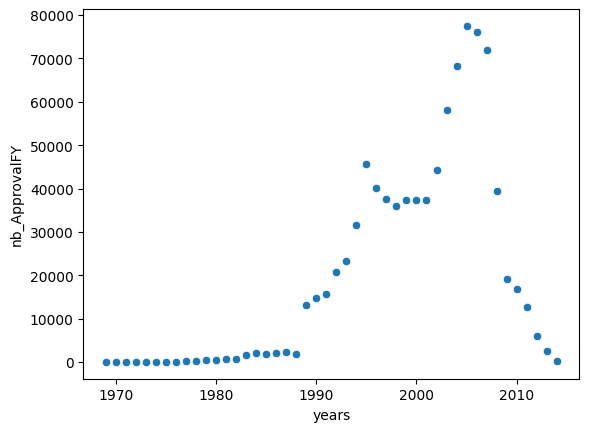

In [26]:
df_2_sum_years = df_2.groupby('ApprovalFY')['SBA_loan_float'].count()


df_2_sum_years = pd.DataFrame(df_2_sum_years).reset_index()
df_2_sum_years.columns = ['years', 'nb_ApprovalFY']

sns.scatterplot(x = "years", 
                y = "nb_ApprovalFY", 
                data = df_2_sum_years, 
                #hue = "status"
                )


### Sur l'augmentation des crédits fin des années 80

Consolidation des prêts garantis par le gouvernement : Les programmes de prêts garantis par la Small Business Administration (SBA) ont été renforcés dans les années 1980. Ces programmes permettaient de réduire les risques pour les prêteurs privés, rendant ainsi les crédits plus accessibles aux petites entreprises, même si elles étaient jugées plus risquées par les institutions financières.

### Baisse des prêts après la crise des subprimes 

2. Renforcement des régulations bancaires (loi Dodd-Frank) :

Après la crise financière de 2008, le gouvernement américain a mis en place de nouvelles régulations pour stabiliser le système financier et éviter de futures crises. La loi Dodd-Frank (2010) a notamment imposé des exigences strictes en matière de capital, de liquidité et de transparence pour les banques. Ces nouvelles régulations ont accru la charge administrative et le coût de l'octroi de crédits pour les banques, les incitant à se concentrer davantage sur des prêts jugés moins risqués et plus rentables. Les petites entreprises, souvent perçues comme plus vulnérables, ont donc eu plus de mal à obtenir des financements.

In [27]:
df_2['LowDoc'][(df_2['LowDoc'] != 'Y') & (df_2['LowDoc']!= 'N')].unique()

array([], dtype=object)

In [28]:
df_2['LowDoc'] = df_2['LowDoc'].apply(lambda x : x if x == 'Y' or x == 'N' else 'N' if x['ApprovalFY'] <= 1993 else 'N' if x['bank_loan_float']> 150000 else 'Y')

df_2['LowDoc'].unique()

/tmp/ipykernel_10526/721854825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['LowDoc'] = df_2['LowDoc'].apply(lambda x : x if x == 'Y' or x == 'N' else 'N' if x['ApprovalFY'] <= 1993 else 'N' if x['bank_loan_float']> 150000 else 'Y')


array(['Y', 'N'], dtype=object)

In [29]:
# Assurez-vous que les colonnes 'Lowdoc' et 'MIS_Status' sont de type catégoriel
low_d= df_2['LowDoc'].astype('category')
status_d= df_2['MIS_Status'].astype('category')

# Créez un tableau de contingence entre les deux variables
contingency_table = pd.crosstab(low_d, status_d)

In [30]:
contingency_table

MIS_Status,CHGOFF,P I F
LowDoc,,
N,146254,636076
Y,11241,102568


In [31]:
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print("Statistique Chi-2:", chi2)
print("Degrés de liberté:", dof)
print("P-value:", p)
print("Tableau des valeurs attendues :\n", expected)

Statistique Chi-2: 5332.005904221699
Degrés de liberté: 1
P-value: 0.0
Tableau des valeurs attendues :
 [[137493.24976371 644836.75023629]
 [ 20001.75023629  93807.24976371]]


In [32]:
df_2['MIS_Status'].isna().sum()

np.int64(1991)

In [38]:
df_2_chi2 = df_2[['State', 'NAICS','UrbanRural','LowDoc','MIS_Status']]

for column in df_2_chi2.columns:
    df_var = df_2_chi2[column].astype('category')
    df_cible = df_2_chi2['MIS_Status'].astype('category')
    contingency_table = pd.crosstab(df_var, df_cible)

    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    val_crit = stats.chi2.ppf(0.95, dof)

    print(f'le résultat pour {column}')
    print("Statistique Chi-2:", chi2)
    print("Degrés de liberté:", dof)
    print("P-value:", p)
    print("Valeur critique du chi2 : ", val_crit)
    print("Tableau des valeurs attendues :\n", expected)
    print('')
    print('================================================================================')

le résultat pour State
Statistique Chi-2: 11155.73713419692
Degrés de liberté: 50
P-value: 0.0
Valeur critique du chi2 :  67.5048065495412
Tableau des valeurs attendues :
 [[   421.27189338   1975.72810662]
 [  1468.21251452   6885.78748548]
 [  1111.26499034   5211.73500966]
 [  3094.59970741  14513.40029259]
 [ 22913.53540737 107462.46459263]
 [  3617.10339494  16963.89660506]
 [  2126.39492617   9972.60507383]
 [   282.78117499   1326.21882501]
 [   384.54021807   1803.45978193]
 [  7237.01878417  33940.98121583]
 [  3911.3082967   18343.6917033 ]
 [   632.52296382   2966.47703618]
 [  2105.12921941   9872.87078059]
 [  1666.10661212   7813.89338788]
 [  5197.44418146  24375.55581854]
 [  2473.50047036  11600.49952964]
 [  2011.27891024   9432.72108976]
 [  1354.3267461    6351.6732539 ]
 [  1681.74833031   7887.25166969]
 [  4403.75879535  20653.24120465]
 [  2326.74951876  10912.25048124]
 [  1042.19538079   4887.80461921]
 [  3598.12243354  16874.87756646]
 [  4278.97654908  2006

In [34]:
df_var = df_2_chi2['State'].astype('category')
df_cible = df_2_chi2['MIS_Status'].astype('category')
contingency_table = pd.crosstab(df_var, df_cible)
contingency_table['ratio'] = contingency_table['CHGOFF'] / (contingency_table['CHGOFF'] + contingency_table['P I F'])
contingency_table.sort_values(by = 'ratio', ascending=False)

MIS_Status,CHGOFF,P I F,ratio
State,,,
FL,11274,29904,0.273787
DC,387,1222,0.240522
GA,5336,16919,0.239766
NV,1863,6133,0.232991
IL,6707,22866,0.226795
MI,4610,15863,0.225175
TN,1994,7398,0.212308
AZ,3656,13952,0.207633
SC,1144,4449,0.204541
